In [83]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
import ipywidgets as widgets

In [84]:
f = uproot.open("/home/users/hdhoang2001/cmssw/src/RecoTracker/LSTCore/standalone/no_cuts.root:tree")

In [85]:
tree = f.arrays(["t3_residual", "t3_isFake", "t3_isPerfect", "t3_region", "t3_rzChiSquared"], library="np")

In [86]:
res = np.concatenate(tree["t3_residual"])
isfake = np.concatenate(tree["t3_isFake"])
isperfect = np.concatenate(tree["t3_isPerfect"])
region = np.concatenate(tree["t3_region"])
rzchi2 = np.concatenate(tree["t3_rzChiSquared"])

In [87]:
res_fake = res[isfake==1]
res_75_99 = res[((1-isfake) & (1-isperfect))==1]
res_100 = res[isperfect==1]

In [88]:
def plot_hist(fake, real_75_99, real_100, xlabel, min=0, max=250, cut=0, save_file=None, output_stats=False, title=None):
    fig = plt.figure(figsize=(12, 6))
    histogram = fig.add_subplot(111)
    bins = np.linspace(min, max, 100)
    sorted_real_100 = np.sort(np.abs(real_100))
    
    loose_cut = 0
    tight_cut = 0
    fake_remained_loose = 0
    fake_remained_tight = 0
    
    
    if len(sorted_real_100) != 0:
        loose_cut = sorted_real_100[int(len(sorted_real_100)*0.99)]
        tight_cut = sorted_real_100[int(len(sorted_real_100)*0.80)]
        fake_remained_loose = len(fake[fake<loose_cut]) / len(fake) * 100
        fake_remained_tight = len(fake[fake<tight_cut]) / len(fake) * 100
    else:
        loose_cut = 0
        tight_cut = 0
    if cut != 0:
        histogram.hist(np.clip(fake[fake<cut], bins[0], bins[-1]), bins=bins, 
                       histtype="step", label="fake match (yield: {})".format(len(fake[fake<cut])))
        histogram.hist(np.clip(real_75_99[real_75_99<cut], bins[0], bins[-1]), bins=bins, 
                       histtype="step", label="75-99% match (yield: {})".format(len(real_75_99[real_75_99<cut])))
        histogram.hist(np.clip(real_100[real_100<cut], bins[0], bins[-1]), bins=bins, 
                       histtype="step", label="100% match (yield: {})".format(len(real_100[real_100<cut])))
    else:
        histogram.hist(np.clip(fake, bins[0], bins[-1]), bins=bins, 
                       histtype="step", label="<75% match (yield: {})".format(len(fake)))
        histogram.hist(np.clip(real_75_99, bins[0], bins[-1]), bins=bins, 
                       histtype="step", label="75-99% match (yield: {})".format(len(real_75_99)))
        histogram.hist(np.clip(real_100, bins[0], bins[-1]), bins=bins, 
                       histtype="step", label="100% match (yield: {})".format(len(real_100)))
        
    if output_stats:
        cell_text = [["cut value", loose_cut, tight_cut],
                     ["true (100% match) remained", "99%", "80%"],
                     ["fake (<75% match) remained", "{:.2f}%".format(fake_remained_loose), "{:.2f}%".format(fake_remained_tight)]]
        histogram.table(cell_text, bbox=[0.1, -0.35, 0.8, 0.2], cellLoc="center")
    
    if title:
        histogram.set_title(title)
    
    histogram.legend()
    histogram.set_xlabel(xlabel)
    histogram.set_ylabel("yield")
    histogram.set_xlim(left=min)
    if save_file:
        if output_stats:
            fig.savefig(save_file, bbox_inches="tight")
        else:
            fig.savefig(save_file)
    return loose_cut, tight_cut


(6.985329, 2.0048535)

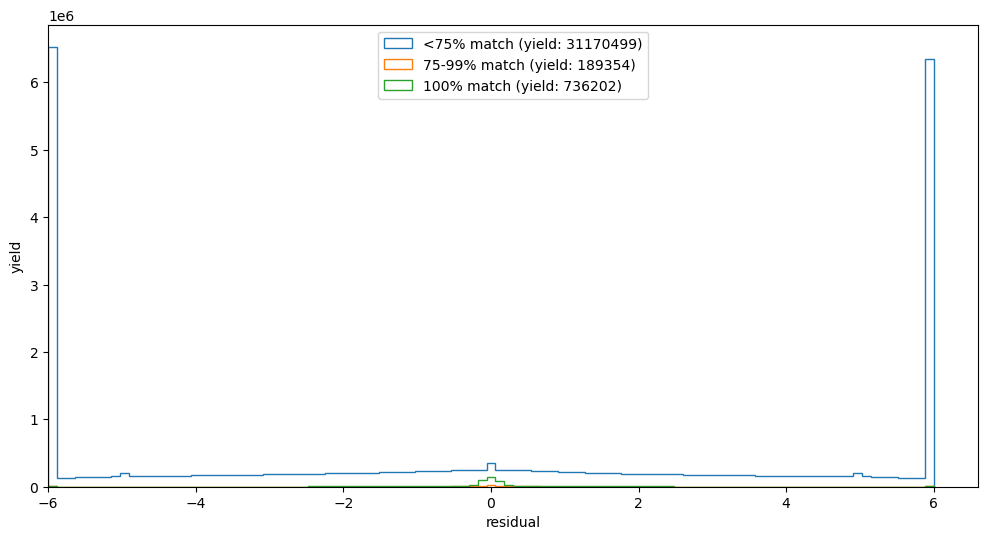

In [89]:
plot_hist(res_fake, res_75_99, res_100, min=-6, max=6, xlabel="residual")

In [90]:
rzchi2_fake = rzchi2[isfake==1]
rzchi2_75_99 = rzchi2[((1-isfake) & (1-isperfect))==1]
rzchi2_100 = rzchi2[isperfect==1]

(100.52761, 10.752856)

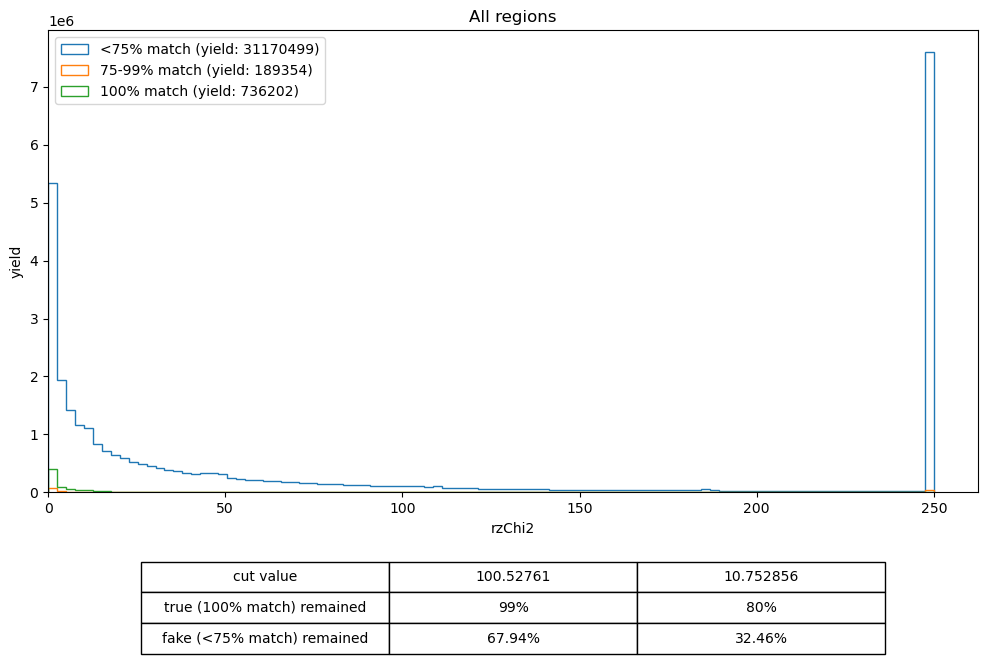

In [91]:
plot_hist(rzchi2_fake, rzchi2_75_99, rzchi2_100, xlabel="rzChi2", output_stats=True, title="All regions")

In [92]:
res_by_region = [res[region==i] for i in range(26)]
isfake_by_region = [isfake[region==i] for i in range(26)]
isperfect_by_region = [isperfect[region==i] for i in range(26)]

In [93]:
res_fake_by_region = [res_by_region[i][isfake_by_region[i]==1] for i in range(25)]
res_75_99_by_region = [res_by_region[i][((1-isfake_by_region[i]) & (1-isperfect_by_region[i]))==1] for i in range(25)]
res_100_by_region = [res_by_region[i][isperfect_by_region[i]==1] for i in range(25)]

In [94]:
for i in range(25):
    plot_hist(res_fake_by_region[i], 
              res_75_99_by_region[i], 
              res_100_by_region[i], 
              xlabel="t3 linear residual",
              min=-6,
              max=6,
              save_file=f"t3_res_by_region/region_{i}.png" if i != 25 else "high_pt_no_helix.png",
              title=f"Region {i}" if i != 25 else "pt>100, helix calculation returns NaN",
              output_stats=False)
    plt.close()

In [95]:
rzchi2_by_region = [rzchi2[region==i] for i in range(26)]

In [96]:
# [len(rzchi2_by_region[i]) for i in range(26)]
# len(rzchi2_by_region)


In [97]:
rzchi2_fake_by_region = [rzchi2_by_region[i][isfake_by_region[i]==1] for i in range(26)]
rzchi2_75_99_by_region = [rzchi2_by_region[i][((1-isfake_by_region[i]) & (1-isperfect_by_region[i]))==1] for i in range(26)]
rzchi2_100_by_region = [rzchi2_by_region[i][isperfect_by_region[i]==1] for i in range(26)]

In [98]:
loose_cuts = []
tight_cuts = []
for i in range(26):
    loose_cut, tight_cut = plot_hist(rzchi2_fake_by_region[i], 
              rzchi2_75_99_by_region[i], 
              rzchi2_100_by_region[i], 
              xlabel="t3 r-z chi2", 
              save_file=f"t3_rzchi2_by_region/region_{i}.png" if i != 25 else "t3_rzchi2_by_region/high_pt_no_helix.png",
              output_stats=True,
              title=f"Region {i}" if i != 25 else "pt>100, helix calculation returns NaN")
    loose_cuts.append(loose_cut)
    tight_cuts.append(tight_cut)
    plt.close()

In [99]:
# reg = 0
# widgets.interact(plot_hist, 
#                  fake=widgets.fixed(rzchi2_fake_by_region[reg]), 
#                  real_75_99=widgets.fixed(rzchi2_75_99_by_region[reg]), 
#                  real_100=widgets.fixed(rzchi2_100_by_region[reg]),
#                  min=widgets.fixed(0),
#                  max=widgets.fixed(250),
#                  xlabel=widgets.fixed("rzChi2"),
#                  cut=widgets.FloatText(value=0, description="cut"),
#                  save_file=widgets.fixed(None))

In [100]:
len(rzchi2)

32096055

In [101]:
sum([len(rzchi2_by_region[i]) for i in range(26)])

30666814

In [102]:
len(rzchi2[region==-1])

1429241